In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from pathlib import Path

import torch
from torch import nn

from scipy.stats import rankdata

import cocoex

BASE_PATH = Path("data/2d/selected_for_plot/")
MODEL_PATH = Path(BASE_PATH / "models/simple_tanh")
ELA_PATH = Path(MODEL_PATH / "ela_data")

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
# Define parameters

FEATURES = ['ela_distr.skewness', 'fitness_distance.fitness_std',
            'nbc.nn_nb.sd_ratio', 'nbc.nb_fitness.cor',
            'ela_meta.lin_simple.adj_r2', 'ela_meta.lin_w_interact.adj_r2',
            'ela_meta.quad_simple.adj_r2', 'ela_meta.quad_w_interact.adj_r2']

DIM = 2

x1 = np.linspace(-5, 5, 150)
x2 = np.linspace(-5, 5, 150)

X1, X2 = np.meshgrid(x1, x2)
X = np.c_[X1.flatten(), X2.flatten()]

label_dict = {
    'ela_distr.skewness': "skewness",
    'fitness_distance.fitness_std': "fitness_std",
    'nbc.nn_nb.sd_ratio': "nbc.sd_ratio",
    'nbc.nb_fitness.cor': "nbc.cor",
    'ela_meta.lin_simple.adj_r2': "linear $R^2$",
    'ela_meta.lin_w_interact.adj_r2': "linear $R^2$ w.i.",
    'ela_meta.quad_simple.adj_r2': "quad $R^2$",
    'ela_meta.quad_w_interact.adj_r2': "quad $R^2$ w.i."
}

# Initialize BBOB Suite
suite = cocoex.Suite("bbob", f"instances:{1}", f"function_indices:{range(1,25)} dimensions:{DIM}")

In [3]:
orig_bbob = pd.read_parquet(ELA_PATH / "bbob_ela_sanity_check_data_2d.parquet")
min_max_ela = pd.read_csv(ELA_PATH / "new_minmax.csv")
ela_data_comb= pd.read_csv(ELA_PATH / "ela_data_comb.csv")
#x-min/(max-min)
for feature in FEATURES:
    Min = min_max_ela[feature].iloc[0]
    Max = min_max_ela[feature].iloc[1]
    if ela_data_comb[feature].min() < Min:
        Min = ela_data_comb[feature].min()
    if ela_data_comb[feature].max() > Max:
        Max = ela_data_comb[feature].max()
    orig_bbob[feature] = (orig_bbob[feature] - Min) / (Max - Min)
    ela_data_comb[feature] = (ela_data_comb[feature] - Min) / (Max - Min)

In [4]:
best_samples = np.array([[1, '9'],
                         [2, '9'],
                         [9, 11],
                         [14, '8'],
                         [21, '6']], dtype=object)

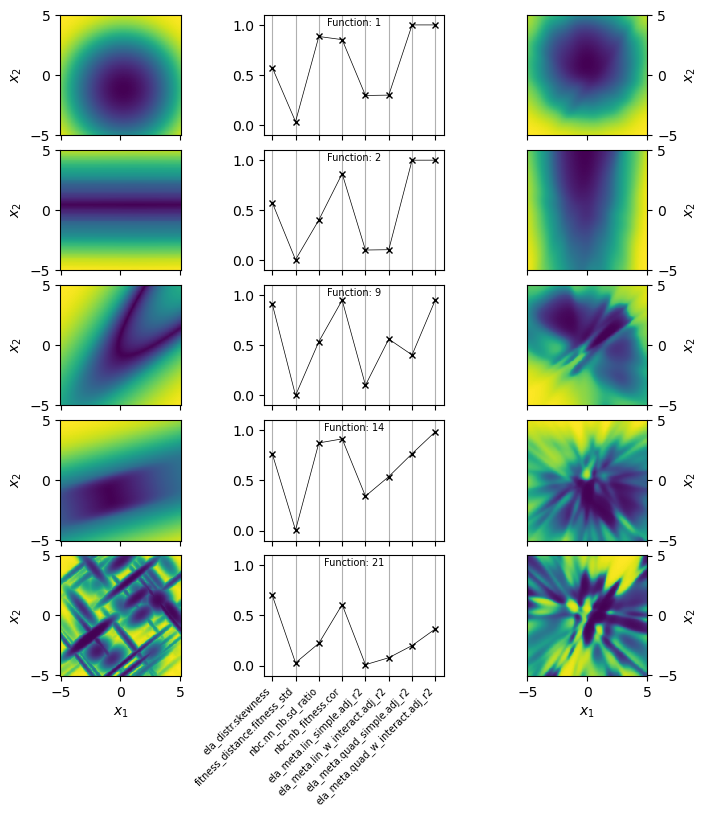

In [5]:
#width: 7.00697
#heigth: 8.66367
fig, ax = plt.subplots(5, 3, figsize=[7.00697, 8])

nn_rep = 0
for i, (fid, rep) in enumerate(best_samples):
    
    ###################### Plot Original Function Contour ###########################
    
    problem = suite[fid-1]
    y = pd.DataFrame(X).apply(lambda x: problem(x), axis = 1)
    y = rankdata(y).reshape(X1.shape)
    ax[i, 0].pcolormesh(X1, X2, y)
    ax[i, 0].set_aspect(1)
    ax[4, 0].set_xlabel("$x_1$")
    ax[i, 0].set_ylabel("$x_2$")
    fig.tight_layout()    

    
    ###################### Plot NN Contour ###########################
    model = nn.Sequential(
                nn.Linear(DIM, 512),
                nn.Tanh(),
                nn.Linear(512, 1),
                nn.Sigmoid()
                )
    model.load_state_dict(torch.load(Path(MODEL_PATH / f"f{fid}_d2_i1_rep{rep}_cma_sample_NNrep_{nn_rep}_NEpochs5000.pt"), map_location=torch.device('cpu')), strict=False)
    print()
    y = model.forward(torch.Tensor(X)).detach().numpy()
    y = rankdata(y).reshape(X1.shape)
    ax[i, 2].pcolormesh(X1, X2, y)
    ax[i, 2].set_aspect(1)
    ax[4, 2].set_xlabel("$x_1$")
    ax[i, 2].set_ylabel("$x_2$")
    ax[i, 2].yaxis.set_label_position("right")
    ax[i, 2].yaxis.tick_right()
    ############################ Parallel Plots 2d #########################################

    for rep in range(1, 7):
        if rep == 6:
            data = ela_data_comb.query(f"fid=={fid} & nn_rep == 'orig'")
            Means = data[FEATURES].mean().to_numpy()
            ax[i, 1].plot(FEATURES, Means, label=rep, color="black", linewidth=.5, marker="x", markersize=5)
        else:
            data = ela_data_comb.query(f"fid=={fid} & nn_rep == {rep}")
            Means = data[FEATURES].mean().to_numpy()
            tenth_qu = data[FEATURES].quantile(.1).to_numpy()
            ninetyth_qu = data[FEATURES].quantile(.9).to_numpy()
            ax[i, 1].plot(FEATURES, Means, linewidth=.3)
            ax[i, 1].fill_between(FEATURES, tenth_qu, ninetyth_qu, alpha=0.15)
        



    ax[i, 1].grid(True, axis='x')
    ax[i, 1].set_ylim(-.1, 1.1)
    #[label_dict[x] for x in FEATURES]
    ax[i, 1].set_xticklabels(FEATURES, rotation=45, ha='right', fontsize=7)
    ax[i, 1].set_title(f"Function: {fid}", fontsize = 7, y=.844)
    if i < 4:
        ax[i, 0].xaxis.set_ticklabels([])
        ax[i, 1].xaxis.set_ticklabels([])
        ax[i, 2].xaxis.set_ticklabels([])
    
    
fig.tight_layout(pad=0.1)

#fig.savefig("5_funcs_parallelplots_2d_new_minmax.png", dpi=300)